### Introduction:   
In this note book we will build a K nearest neighbour classifier on Drug Review dataset to classify the sentiments of the patients based on the ratings given against each drug.

In [1]:
# libraries
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")
import pandas as pd  
import numpy as np
import nltk
import re
from tqdm import tqdm_notebook as tqdm
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import Normalizer
from scipy.sparse import hstack
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from pactools.grid_search import GridSearchCVProgressBar
import pickle
import matplotlib.pyplot as plt
import seaborn as sn
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import pickle

C:\Users\sairam.chennapragada\AppData\Local\Continuum\anaconda3\lib\importlib\_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 216, got 192
  return f(*args, **kwds)
C:\Users\sairam.chennapragada\AppData\Local\Continuum\anaconda3\lib\importlib\_bootstrap.py:219: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
  return f(*args, **kwds)
C:\Users\sairam.chennapragada\AppData\Local\Continuum\anaconda3\lib\importlib\_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)


### Loading the dataset:     

In [2]:
# Data source https://archive.ics.uci.edu/ml/datasets/Drug+Review+Dataset+%28Drugs.com%29
drug_review_train = pd.read_csv("Train_raw.tsv", sep='\t')
drug_review_test = pd.read_csv("Test_raw.tsv", sep='\t')

In [3]:
drug_review_train.head()

,Unnamed: 0,drugName,condition,review,rating,date,usefulCount
0,206461,Valsartan,Left Ventricular Dysfunction,"""It has no side effect, I take it in combinati...",9.0,"May 20, 2012",27
1,95260,Guanfacine,ADHD,"""My son is halfway through his fourth week of ...",8.0,"April 27, 2010",192
2,92703,Lybrel,Birth Control,"""I used to take another oral contraceptive, wh...",5.0,"December 14, 2009",17
3,138000,Ortho Evra,Birth Control,"""This is my first time using any form of birth...",8.0,"November 3, 2015",10
4,35696,Buprenorphine / naloxone,Opiate Dependence,"""Suboxone has completely turned my life around...",9.0,"November 27, 2016",37


The patient ID(Unnamed) ,date column can be removed from the analysis. Since they donot directly contribute for the algorithm during the learning process. Also, we are considering the rating column as the target for the classification task

In [4]:
# Checking for missing values in each column of train
print("="*50)
print("Trainset")
print("="*50)
print("No.of rows with nan values in drugName: ",drug_review_train['drugName'].isnull().values.sum())
print("No.of rows with nan values in condition: ",drug_review_train['condition'].isnull().values.sum())
print("No.of rows with nan values in review: ",drug_review_train['review'].isnull().values.sum())
print("No.of rows with nan values in rating: ",drug_review_train['rating'].isnull().values.sum())
print("No.of rows with nan values in usefulCount: ",drug_review_train['usefulCount'].isnull().values.sum())
# Replacing all 'nan' with 'Other'
drug_review_train.replace(np.nan, "Other", inplace = True, regex = True)
print("="*50)
print("Testset")
print("="*50)
# Checking for missing values in each column of test
print("No.of rows with nan values in drugName: ",drug_review_test['drugName'].isnull().values.sum())
print("No.of rows with nan values in condition: ",drug_review_test['condition'].isnull().values.sum())
print("No.of rows with nan values in review: ",drug_review_test['review'].isnull().values.sum())
print("No.of rows with nan values in rating: ",drug_review_test['rating'].isnull().values.sum())
print("No.of rows with nan values in usefulCount: ",drug_review_test['usefulCount'].isnull().values.sum())
# Replacing all 'nan' with 'Other'
drug_review_test.replace(np.nan, "Other", inplace = True, regex = True)

Trainset
No.of rows with nan values in drugName:  0
No.of rows with nan values in condition:  899
No.of rows with nan values in review:  0
No.of rows with nan values in rating:  0
No.of rows with nan values in usefulCount:  0
Testset
No.of rows with nan values in drugName:  0
No.of rows with nan values in condition:  295
No.of rows with nan values in review:  0
No.of rows with nan values in rating:  0
No.of rows with nan values in usefulCount:  0


All missing values in the drugName column are replaced by the word 'Other'

In [5]:
drug_review_test.head()

,Unnamed: 0,drugName,condition,review,rating,date,usefulCount
0,163740,Mirtazapine,Depression,"""I&#039;ve tried a few antidepressants over th...",10.0,"February 28, 2012",22
1,206473,Mesalamine,"Crohn's Disease, Maintenance","""My son has Crohn&#039;s disease and has done ...",8.0,"May 17, 2009",17
2,159672,Bactrim,Urinary Tract Infection,"""Quick reduction of symptoms""",9.0,"September 29, 2017",3
3,39293,Contrave,Weight Loss,"""Contrave combines drugs that were used for al...",9.0,"March 5, 2017",35
4,97768,Cyclafem 1 / 35,Birth Control,"""I have been on this birth control for one cyc...",9.0,"October 22, 2015",4


In [6]:
# dropping the patient id column, date from train and test 
del drug_review_train['Unnamed: 0']
del drug_review_train['date']
del drug_review_test['Unnamed: 0']
del drug_review_test['date']
# moving rating column to the end in train
drug_review_train = drug_review_train[['drugName', 'condition', 'review', 'usefulCount', 'rating']]
drug_review_test = drug_review_test[['drugName', 'condition', 'review', 'usefulCount', 'rating']]

Any rating below 5.0 is considered to be Negative (NEG) and any rating above 5.0 is considered to be positive (POS). In both train and test datasets

In [7]:
# Creating a class label from the rating column
# Rating > 5 is 'POS' and Rating < 5 is 'NEG'
drug_review_train['rating'] = ['POS' if i > 5.0 else 'NEG' for i in tqdm(drug_review_train['rating'])]
drug_review_test['rating'] = ['POS' if i > 5.0 else 'NEG' for i in tqdm(drug_review_test['rating'])]

In [8]:
drug_review_test.head()

,drugName,condition,review,usefulCount,rating
0,Mirtazapine,Depression,"""I&#039;ve tried a few antidepressants over th...",22,POS
1,Mesalamine,"Crohn's Disease, Maintenance","""My son has Crohn&#039;s disease and has done ...",17,POS
2,Bactrim,Urinary Tract Infection,"""Quick reduction of symptoms""",3,POS
3,Contrave,Weight Loss,"""Contrave combines drugs that were used for al...",35,POS
4,Cyclafem 1 / 35,Birth Control,"""I have been on this birth control for one cyc...",4,POS


In [9]:
drug_review_train.head()

,drugName,condition,review,usefulCount,rating
0,Valsartan,Left Ventricular Dysfunction,"""It has no side effect, I take it in combinati...",27,POS
1,Guanfacine,ADHD,"""My son is halfway through his fourth week of ...",192,POS
2,Lybrel,Birth Control,"""I used to take another oral contraceptive, wh...",17,NEG
3,Ortho Evra,Birth Control,"""This is my first time using any form of birth...",10,POS
4,Buprenorphine / naloxone,Opiate Dependence,"""Suboxone has completely turned my life around...",37,POS


In [10]:
# X train test split
X_train = drug_review_train.copy(deep=True)
del X_train['rating']
X_test = drug_review_test.copy(deep=True)
del X_test['rating']

# y train test split
y_train = drug_review_train['rating']
y_test = drug_review_test['rating']

### Cleaning & Text Preprocessing:  

The columns 'review', 'condition', 'drugName' contains text data. These text fields should be cleaned before vectorization

In [11]:
def text_preprocessor(phrase):
    """Method takes a phrase, cleans and return the phrase"""
    # remove short forms
    phrase = re.sub(r"won't", "will not", phrase)  # substitute "won't" with "will not" 
    phrase = re.sub(r"can\'t", "can not", phrase)  # substitute "can't" with "can not"
    phrase = re.sub(r"n\'t", " not", phrase)       # substitute "n't" with "not"
    phrase = re.sub(r"\'re", " are", phrase)       # substitute "'re" with "are"
    phrase = re.sub(r"\'s", " is", phrase)         # substitute "'s" with "is" 
    phrase = re.sub(r"\'d", " would", phrase)      # substitute "'d"  with " would"
    phrase = re.sub(r"\'ll", " will", phrase)      # substitute "'ll" with " will"
    phrase = re.sub(r"\'t", " not", phrase)        # substitute "'t" with " not"
    phrase = re.sub(r"\'ve", " have", phrase)      # substitute "'ve" with " have"
    phrase = re.sub(r"\'m", " am", phrase)         # substitute "'m" with " am"      
    # remove special characters
    phrase = re.sub('[^A-Za-z]+', ' ', phrase)     # remove all special characters except alphabets
    phrase = phrase.replace('\\r', ' ')
    phrase = phrase.replace('\\n', ' ')
    phrase = phrase.replace('\\"', ' ')    
    # convert to lower case
    phrase = ' '.join(e.lower() for e in phrase.split())
    return phrase

    
# Text preprocessing - reviews
X_train['review'] = [text_preprocessor(i) for i in tqdm(X_train['review'])] 
X_test['review'] = [text_preprocessor(i) for i in X_test['review']]     

# Text preprocessing - condition
X_train['condition'] = [text_preprocessor(i) for i in tqdm(X_train['condition'])] 
X_test['condition'] = [text_preprocessor(i) for i in tqdm(X_test['condition'])]     

# Text preprocessing - drugName
X_train['drugName'] = [text_preprocessor(i) for i in tqdm(X_train['drugName'])] 
X_test['drugName'] = [text_preprocessor(i) for i in tqdm(X_test['drugName'])]    

###  Encoding categorical features: (TFIDF)

Considering the term frequency inverse document frequency(TF-IDF) algorithm for vectorization of the text features. Other possible approaches are:   
* Bag of Words (BOW)   
* Word to Vector (Word2Vec)  
* Average Word to Vector (AvgWord2Vec)     
* TFIDFW2V
* Google Word2Vec   
* Hashing vectorizer   
* GloVe  

In [12]:
# encoding categorical features: drugName column
tfidfvectorizer_drugName = TfidfVectorizer(min_df=10,ngram_range=(1,4))
tfidfvectorizer_drugName.fit(X_train['drugName'].values) 
# Save the fitted vectorizer to the disk - To reuse it in production
pickle.dump(tfidfvectorizer_drugName, open("tfidfvectorizer_drugName.pickle", "wb"))
# Fit to X_train['drugName'] and transform X_train['drugName'] X_test['drugName'] 
X_train_drugName_tfidf = tfidfvectorizer_drugName.transform(X_train['drugName'].values)
X_test_drugName_tfidf = tfidfvectorizer_drugName.transform(X_test['drugName'].values)
print("drugName (TFIDF) After vectorizations")
print(X_train_drugName_tfidf.shape, y_train.shape)
print(X_train_drugName_tfidf.shape, y_test.shape)
print("="*100)

# encoding categorical features: condition column
tfidfvectorizer_condition = TfidfVectorizer(min_df=10,ngram_range=(1,4))
tfidfvectorizer_condition.fit(X_train['condition'].values) 
# Save the fitted vectorizer to the disk - To reuse it in production
pickle.dump(tfidfvectorizer_condition, open("tfidfvectorizer_condition.pickle", "wb"))
# Fit to X_train['condition'] and transform X_train['condition'] X_test['condition'] 
X_train_condition_tfidf = tfidfvectorizer_condition.transform(X_train['condition'].values)
X_test_condition_tfidf = tfidfvectorizer_condition.transform(X_test['condition'].values)
print("condition (TFIDF) After vectorizations")
print(X_train_condition_tfidf.shape, y_train.shape)
print(X_test_condition_tfidf.shape, y_test.shape)
print("="*100)

# encoding categorical features: reviews column
tfidfvectorizer_review = TfidfVectorizer(min_df=10,ngram_range=(1,4))
tfidfvectorizer_review.fit(X_train['review'].values) 
# Save the fitted vectorizer to the disk - To reuse it in production
pickle.dump(tfidfvectorizer_review, open("tfidfvectorizer_review.pickle", "wb"))
# Fit to X_train['review'] and transform X_train['review'] X_test['review'] 
X_train_review_tfidf = tfidfvectorizer_review.transform(X_train['review'].values)
X_test_review_tfidf = tfidfvectorizer_review.transform(X_test['review'].values)
print("reviews (TFIDF) After vectorizations")
print(X_train_review_tfidf.shape, y_train.shape)
print(X_test_review_tfidf.shape, y_test.shape)
print("="*100)

C:\Users\sairam.chennapragada\AppData\Local\Continuum\anaconda3\lib\site-packages\numpy\matrixlib\defmatrix.py:71: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)
C:\Users\sairam.chennapragada\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:5: ResourceWarning: unclosed file <_io.BufferedWriter name='tfidfvectorizer_drugName.pickle'>
  """


drugName (TFIDF) After vectorizations
(161297, 1960) (161297,)
(161297, 1960) (53766,)


C:\Users\sairam.chennapragada\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:18: ResourceWarning: unclosed file <_io.BufferedWriter name='tfidfvectorizer_condition.pickle'>


condition (TFIDF) After vectorizations
(161297, 1257) (161297,)
(53766, 1257) (53766,)


C:\Users\sairam.chennapragada\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:31: ResourceWarning: unclosed file <_io.BufferedWriter name='tfidfvectorizer_review.pickle'>


reviews (TFIDF) After vectorizations
(161297, 327224) (161297,)
(53766, 327224) (53766,)


Normalizing the numerical feature 'usefulCount'

### Encoding numerical features:

In [13]:
normalizer_usefulCount = Normalizer()

# encoding numerical features: Price
normalizer_usefulCount.fit(X_train['usefulCount'].values.reshape(-1,1))

# Save the fitted normalizer to the disk - To reuse it in production
pickle.dump(normalizer_usefulCount, open("normalizer_usefulCount.pickle", "wb"))

X_train_usefulCount_norm = normalizer_usefulCount.transform(X_train['usefulCount'].values.reshape(-1,1))
X_test_usefulCount_norm = normalizer_usefulCount.transform(X_test['usefulCount'].values.reshape(-1,1))
print("usefulCount After vectorizations")
print(X_train_usefulCount_norm.shape, y_train.shape)
print(X_test_usefulCount_norm.shape, y_test.shape)
print("="*100)

C:\Users\sairam.chennapragada\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:7: ResourceWarning: unclosed file <_io.BufferedWriter name='normalizer_usefulCount.pickle'>
  import sys


usefulCount After vectorizations
(161297, 1) (161297,)
(53766, 1) (53766,)


### Concatinating all the features

In [14]:
# X train stack
X_tr = hstack((X_train_drugName_tfidf, 
               X_train_condition_tfidf, 
               X_train_review_tfidf, 
               X_train_usefulCount_norm)).tocsr()

# X test stack
X_te = hstack((X_test_drugName_tfidf, 
               X_test_condition_tfidf, 
               X_test_review_tfidf, 
               X_test_usefulCount_norm)).tocsr()

In [15]:
# Save the preprocessed, cleaned, and stacked train and test data to disk
np.save('X_train',X_tr)
np.save('y_train',y_train)
np.save('X_test',X_te)
np.save('y_test',y_test)

### Apply KNN with Grid Search CV

In [16]:
neigh = KNeighborsClassifier()
parameters = {'n_neighbors':[3,5,7,10,15,30,50,100]}
clf = GridSearchCV(neigh, 
                   parameters, 
                   cv=3, 
                   scoring='roc_auc',
                   return_train_score=True,
                   verbose = 100)
clf.fit(X_tr, y_train)

Fitting 3 folds for each of 8 candidates, totalling 24 fits
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[CV] n_neighbors=3 ...................................................
[CV] ... n_neighbors=3, score=(train=0.925, test=0.711), total=12.0min
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed: 32.4min remaining:    0.0s
[CV] n_neighbors=3 ...................................................
[CV] ... n_neighbors=3, score=(train=0.926, test=0.718), total=10.4min
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed: 63.1min remaining:    0.0s
[CV] n_neighbors=3 ...................................................
[CV] ... n_neighbors=3, score=(train=0.926, test=0.714), total=10.2min
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed: 93.7min remaining:    0.0s
[CV] n_neighbors=5 ...................................................
[CV] ... n_neighbors=5, score=(train=0.894, test=0.734), total=10.8min
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed

GridSearchCV(cv=3, error_score='raise-deprecating',
             estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30,
                                            metric='minkowski',
                                            metric_params=None, n_jobs=None,
                                            n_neighbors=5, p=2,
                                            weights='uniform'),
             iid='warn', n_jobs=None,
             param_grid={'n_neighbors': [3, 5, 7, 10, 15, 30, 50, 100]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
             scoring='roc_auc', verbose=100)

In [17]:
results = pd.DataFrame.from_dict(clf.cv_results_)
results = results.sort_values(['param_n_neighbors'])
results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_neighbors,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,mean_train_score,std_train_score
0,5.519649,6.033249,647.725714,51.959966,3,{'n_neighbors': 3},0.710785,0.717861,0.713782,0.714143,0.002900,8,0.925369,0.925899,0.925733,0.925667,0.000221
1,1.256072,0.012028,660.302767,9.345397,5,{'n_neighbors': 5},0.733901,0.738810,0.737670,0.736794,0.002098,7,0.894013,0.893525,0.893603,0.893714,0.000214
2,1.322742,0.102000,656.058524,6.089804,7,{'n_neighbors': 7},0.744372,0.749819,0.749844,0.748011,0.002574,6,0.874627,0.874435,0.874237,0.874433,0.000159
3,1.294407,0.055044,661.480834,2.712912,10,{'n_neighbors': 10},0.752904,0.758061,0.759392,0.756786,0.002798,4,0.855179,0.855926,0.854930,0.855345,0.000423
4,1.340743,0.020823,656.027523,4.814631,15,{'n_neighbors': 15},0.760505,0.762037,0.762629,0.761724,0.000895,2,0.835320,0.836391,0.835812,0.835841,0.000438
5,1.294407,0.029636,654.955795,4.980776,30,{'n_neighbors': 30},0.761573,0.763226,0.764638,0.763146,0.001253,1,0.805918,0.807506,0.805712,0.806379,0.000802
6,1.269406,0.002625,660.472435,10.409011,50,{'n_neighbors': 50},0.758189,0.759910,0.760779,0.759626,0.001076,3,0.788032,0.789100,0.788218,0.788450,0.000466
7,1.329804,0.075290,677.886131,7.693244,100,{'n_neighbors': 100},0.750947,0.751882,0.753103,0.751978,0.000883,5,0.766879,0.769107,0.767547,0.767844,0.000934


Plotting the ROC-AUC for the train and cross validation against the K value (Hyper parameter)

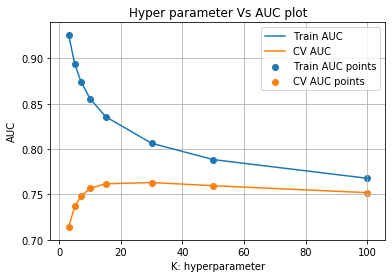

In [18]:
train_auc= results['mean_train_score']
train_auc_std= results['std_train_score']
cv_auc = results['mean_test_score'] 
cv_auc_std= results['std_test_score']
K =  results['param_n_neighbors']

plt.plot(K, train_auc, label='Train AUC')
plt.plot(K, cv_auc, label='CV AUC')
plt.scatter(K, train_auc, label='Train AUC points')
plt.scatter(K, cv_auc, label='CV AUC points')
plt.legend()
plt.xlabel("K: hyperparameter")
plt.ylabel("AUC")
plt.title("Hyper parameter Vs AUC plot")
plt.grid()
plt.show()

Based on the above curve the best K value with maximum Area under the curve is choosen to build the model

### Best K vaule from GridSearchCV

In [46]:
best_k = results[results['rank_test_score'] == 1]['param_n_neighbors']
best_k = int(best_k)
print(best_k)

30


### Build & Save the final model

In [20]:
# Build the final model with best_k value
knn_clf = KNeighborsClassifier(n_neighbors=best_k)
knn_clf.fit(X_tr, y_train)

# save the model to disk
filename = 'knn_classifier.sav'
pickle.dump(knn_clf, open(filename, 'wb'))

C:\Users\sairam.chennapragada\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:7: ResourceWarning: unclosed file <_io.BufferedWriter name='knn_classifier.sav'>
  import sys


In [21]:
knn_clf.classes_

array(['NEG', 'POS'], dtype=object)

### Predict on the train & test set

In [22]:
y_train_predict = knn_clf.predict_proba(X_tr)
y_test_predict = knn_clf.predict_proba(X_te)

### ROC-AUC for train & test set

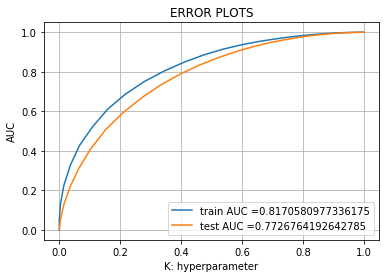

In [23]:
train_fpr, train_tpr, tr_thresholds = roc_curve(y_train, y_train_predict[:,1], pos_label = 'POS')
test_fpr, test_tpr, te_thresholds = roc_curve(y_test, y_test_predict[:,1], pos_label = 'POS')

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("K: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.grid()
plt.show()

### Confusion matrix for train & test set

In [24]:
# Here we dont want to miss any negative comments by falsly classifying them as positive
# Choose a threshold that will give the least fpr
def find_best_threshold(threshould, fpr, tpr):
    t = threshould[np.argmax(tpr*(1-fpr))]
    print("the maximum value of tpr*(1-fpr)", max(tpr*(1-fpr)), "for threshold", np.round(t,3))
    return t

def predict_with_best_t(proba, threshould):
    predictions = []
    for i in proba:
        if i>=threshould:
            predictions.append('POS')
        else:
            predictions.append('NEG')
    return predictions

best_t = find_best_threshold(tr_thresholds, train_fpr, train_tpr)

the maximum value of tpr*(1-fpr) 0.5410343501323724 for threshold 0.733


C:\Users\sairam.chennapragada\AppData\Local\Continuum\anaconda3\lib\site-packages\seaborn\matrix.py:269: PendingDeprecationWarning: 
The label function will be deprecated in a future version. Use Tick.label1 instead.
  fontsize = tick.label.get_size()


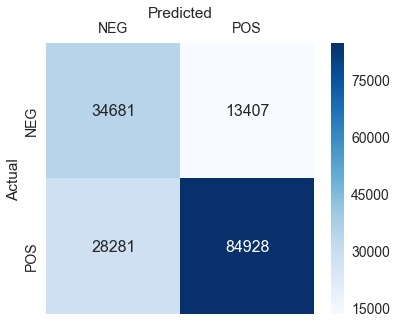

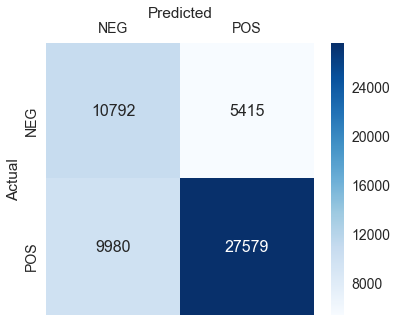

In [25]:
# Train confusion matrix
data = pd.DataFrame(confusion_matrix(y_train, predict_with_best_t(y_train_predict[:,1], best_t)),
                    columns=["NEG", "POS"], 
                    index = ["NEG", "POS"])
data.index.name = 'Actual'
data.columns.name = 'Predicted'
plt.figure(figsize = (6,5))
sn.set(font_scale=1.4)
ax = sn.heatmap(data, cmap="Blues", annot=True,annot_kws={"size": 16}, fmt='g')
ax.xaxis.tick_top() 
ax.xaxis.set_label_position('top')

# Test confusion matrix
data = pd.DataFrame(confusion_matrix(y_test, predict_with_best_t(y_test_predict[:,1], best_t)),
                    columns=["NEG", "POS"], 
                    index = ["NEG", "POS"])
data.index.name = 'Actual'
data.columns.name = 'Predicted'
plt.figure(figsize = (6,5))
sn.set(font_scale=1.4)
ax = sn.heatmap(data, cmap="Blues", annot=True,annot_kws={"size": 16}, fmt='g')
ax.xaxis.tick_top() 
ax.xaxis.set_label_position('top')

### Metrics of evaluation

In [26]:
train_tn, train_fp, train_fn, train_tp = confusion_matrix(y_train,predict_with_best_t(y_train_predict[:,1], best_t)).ravel()
test_tn, test_fp, test_fn, test_tp = confusion_matrix(y_test,predict_with_best_t(y_test_predict[:,1], best_t)).ravel()

# Train metrics
print("="*50)
print("Train - True Positives: ", train_tp)
print("Train - False Positivs: ", train_fp)

# Test metrics
print("="*50)
print("Test - True Positives: ",test_tp)
print("Test - False Positives: ",test_fp)
print("="*50)
print("Best threshold for minimum for fpr: ",best_t )
print("Best K for the model: ", best_k)
print("="*50)
print("Train Classification report")
print(classification_report(y_train, 
                            predict_with_best_t(y_train_predict[:,1], best_t), 
                            target_names=["NEG","POS"]))
print("="*50)
print("Test Classification report")
print(classification_report(y_test, 
                            predict_with_best_t(y_test_predict[:,1], best_t), 
                            target_names=["NEG","POS"]))
print("="*50)

Train - True Positives:  84928
Train - False Positivs:  13407
Test - True Positives:  27579
Test - False Positives:  5415
Best threshold for minimum for fpr:  0.7333333333333333
Best K for the model:  30
Train Classification report
              precision    recall  f1-score   support

         NEG       0.55      0.72      0.62     48088
         POS       0.86      0.75      0.80    113209

    accuracy                           0.74    161297
   macro avg       0.71      0.74      0.71    161297
weighted avg       0.77      0.74      0.75    161297

Test Classification report
              precision    recall  f1-score   support

         NEG       0.52      0.67      0.58     16207
         POS       0.84      0.73      0.78     37559

    accuracy                           0.71     53766
   macro avg       0.68      0.70      0.68     53766
weighted avg       0.74      0.71      0.72     53766



### New data point

Once the model is built and saved, any new data point can be classified using the pre trained classifier. But the new data point has to go through all the preprocessing steps that the test set has went through

In [45]:
def prod_knn_classifier(new_data_point):
    """Methods takes a new data point and classifies using the pretrained model"""
    # Step 1: Consider the same feature that were considered for training the model
    test_data_point = pd.DataFrame(new_data_point)
    # Step 2: Checking for missing values, Cleaning and preprocessing the text data
    test_data_point['drugName'] = text_preprocessor(test_data_point['drugName'][0])
    test_data_point['review'] = text_preprocessor(test_data_point['review'][0])
    test_data_point['condition'] = text_preprocessor(test_data_point['condition'][0])

    # Step 3: Vectorize text features, normalize numerical features
    # Load the pickle file 
    with open("tfidfvectorizer_drugName.pickle", 'rb') as pickle_file:
        tfidfvectorizer_drugName = pickle.load(pickle_file)
    test_data_point_drugName_tfidf = tfidfvectorizer_drugName.transform(test_data_point['drugName'].values)

    # encoding categorical features: condition column
    with open("tfidfvectorizer_condition.pickle", 'rb') as pickle_file:
        tfidfvectorizer_condition = pickle.load(pickle_file)
    test_data_point_condition_tfidf = tfidfvectorizer_condition.transform(test_data_point['condition'].values)

    # encoding categorical features: reviews column
    with open("tfidfvectorizer_review.pickle", 'rb') as pickle_file:
        tfidfvectorizer_review = pickle.load(pickle_file)
    test_data_point_review_tfidf = tfidfvectorizer_review.transform(test_data_point['review'].values)

    # normalize neumerical features: usefulCount
    with open("normalizer_usefulCount.pickle", 'rb') as pickle_file:
        normalizer_usefulCount = pickle.load(pickle_file)
    test_data_usefulCount_normalized = normalizer_usefulCount.transform(test_data_point['usefulCount'].values.reshape(1,-1))
    
    # Step 4: Stack all the features
    X_new_test = hstack((test_data_point_drugName_tfidf, 
                   test_data_point_condition_tfidf, 
                   test_data_point_review_tfidf, 
                   test_data_usefulCount_normalized)).tocsr()

    # Step 5: Load the pre-trained model
    with open("knn_classifier.sav", 'rb') as pickle_file:
        knn_classifier = pickle.load(pickle_file)

    # Step 6: predict
    y_test_predict = knn_classifier.predict_proba(X_new_test)
    

    # Step 7: probabilities of class labels
    classification = None
    NEG_class_prob = y_test_predict[0][0]
    POS_class_prob = y_test_predict[0][1]
    return NEG_class_prob,POS_class_prob

# Classification on a single new data point
new_data_point = {"drugName":"Arthrotec",
                 "condition":"Sciatica",
                 "review":"It works!!!",
                 "usefulCount":[46]}

NEG_class_prob,POS_class_prob = prod_knn_classifier(new_data_point)

print("Probability of class label 'NEG': {}".format(round(NEG_class_prob,2)))
print("Probability of class label 'POS': {}".format(round(POS_class_prob,2)))


Probability of class label 'NEG': 0.07
Probability of class label 'POS': 0.93
Total time elapsed for prediction: 10.76 secs
